# Classifying Damage Level Disaster-Induced Images Via Computer Vision

Source: https://github.com/fractalclockwork/Data200

Video: https://youtu.be/UwdOYl2VrcI

Shirley Li, Kofi Mireku, Brent Thorne

Data200S, UC Berkeley MSSE

**Summary and Introduction**

This notebook serves as a repository for collecting observations and results. It does not represent refinements to models and analyses conducted outside this notebook.

    Model Selection:
        The approach integrates predictive and inferential elements.
        Two model choices:
            Convolutional Neural Network (CNN): Effective for processing grid-like data (e.g., images) and extracting hierarchical features.
            Singular Value Decomposition (SVD) or Principal Component Analysis (PCA): Computationally efficient, providing low-dimensional representations for large, high-dimensional datasets.

    Hyperparameter Tuning:
        The model does not require extensive tuning due to the use of convolutional layers.
        Unlike Support Vector Machines, CNNs perform effectively without extensive hyperparameter adjustments.

    Feature Engineering:
        Image size selection within the interquartile range ensures a balanced and representative sample. (used in initial model, current dev is with weighted bottleneck, w/vgg16)
        Augmentation techniques (flipping, rotation) enhance training data diversity.  (used in initial model, weighted bottleneck for vgg16).
        Resizing images to a common aspect ratio reduces model complexity.

    Cross-Validation:
        Categorical cross-entropy loss function used during cross-validation.
        F1 score is the primary metric for model comparison.
        Precision, recall, and R2 scores provide comprehensive evaluation.

    Bias-Variance Tradeoff and Overfitting:
        Precision, recall, F1 scores, and R2 scores assess bias-variance tradeoff.
        Monitoring training and validation loss helps detect overfitting.
        SVD model uses condition numbers to manage complexity.

    Model Improvement:
        Address label imbalance by augmenting or dropping data based on outcomes.
        Employ k-fold cross-validation for performance estimation on unseen data.
        Use weighted bottleneck and vgg16.
        Explore essemble VGG6, CNN, and SVG. 

    Further Extensions:
        Investigating visualizations of intermediate activations in CNNs.
        Interpreting dimensions of latent space using principal components.
        Exploring Synthetic Minority Oversampling Technique (SMOTE) for data augmentation.


## Library Import and Environment Configuration

In [1]:
import cv2
import re
import io
import os
import pickle
import zipfile
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

from utils import (
    read_files_from_zip,
    data2pd,
    show_balance,
    load_model_data,
    save_model_data,
)



2024-05-09 18:09:10.297880: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%%time
data_dir = '../data'

# Pickle out data to speed this up
train_df, test_df = [], []
if (
    os.path.exists(data_dir)
    & os.path.isfile(f"{data_dir}/train_df.pkl")
    & os.path.isfile(f"{data_dir}/test_df.pkl")
):
    train_df = pd.read_pickle(f"{data_dir}/train_df.pkl")
    test_df = pd.read_pickle(f"{data_dir}/test_df.pkl")
else:
    # Load Test Images
    test_data_images = read_files_from_zip(
        data_file, r"(test)_images_([\w-]*)\.npz"
    )

    # Load Train Images and Labels
    train_data_images = read_files_from_zip(
        data_file, r"satellite-image-data/([\w-]*)/(train)_images\.npz"
    )
    train_data_labels = read_files_from_zip(
        data_file, r"satellite-image-data/([\w-]*)/(train)_labels\.npy"
    )

    # Convert to Dataframe
    train_df = data2pd(train_data_images, train_data_labels)
    test_df = data2pd(test_data_images)

    # Pickle DataFrame
    train_df.to_pickle(f"{data_dir}/train_df.pkl")
    test_df.to_pickle(f"{data_dir}/test_df.pkl")

    # Clean up
    del test_data_images
    del train_data_images
    del train_data_labels

CPU times: user 484 ms, sys: 749 ms, total: 1.23 s
Wall time: 1.82 s


In [3]:
# Configure system type
COLAB = False

# Set data and system paths
if COLAB:
    import sys
    from google.colab import drive

    drive.mount("/content/drive")
    path = "/content/drive/My Drive/Colab Notebooks/grad_project"
    data_dir = f"{path}/data"
    sys.path.insert(
        0, f"{path}/Source"
    )  # for colab to see local libraries
else:
    data_dir = f"../data"
    path = "."

# Set Date Source
data_file = f"{data_dir}/sp24_grad_project_data.zip"
figure_path = f"{path}/../figures"

# Set Default Image Size
SIZE = 120

## EDA

### Label Distribution

In [4]:
show_balance(train_df)

type       label
fire       0        7204
           3        1064
           1          69
           2          43
flood      0        6734
           1         114
           2          97
           3          59
hurricane  1        5236
           0        2631
           3        1740
           2        1544
Name: count, dtype: int64

label,0,1,2,3
type,,,,
fire,7204,69,43,1064
flood,6734,114,97,59
hurricane,2631,5236,1544,1740


label         0     1     2     3
type                             
fire       7204    69    43  1064
flood      6734   114    97    59
hurricane  2631  5236  1544  1740


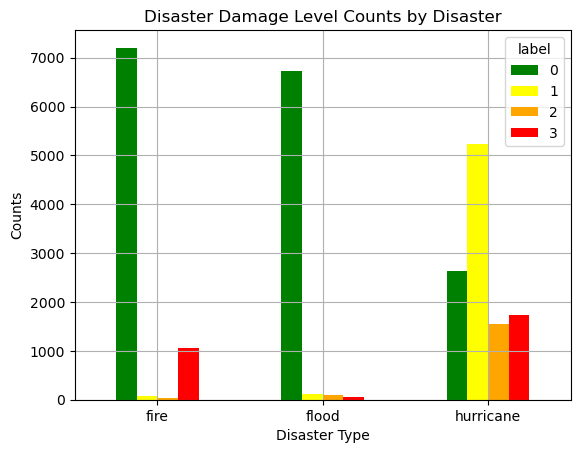

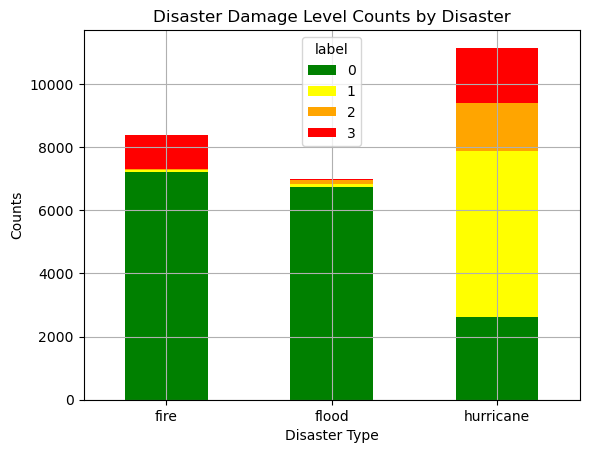

In [5]:
# Label count by disaster type

dd = train_df  # in case we want a different sample
label_counts = dd.groupby("type")["label"].value_counts()
# total_counts = label_counts.groupby(level=0).sum()
# label_ratios = label_counts / total_counts

palette = ["red", "blue", "green", "orange"]
color_dict = {3: "red", 0: "green", 1: "yellow", 2: "orange"}

# Pivot the data for plotting
pivot_df = label_counts.unstack(fill_value=0)
display(pivot_df)
print(pivot_df)

# side-by-side
pivot_df.plot(kind="bar", color=color_dict)
plt.xlabel("Disaster Type")
plt.ylabel("Counts")
plt.title("Disaster Damage Level Counts by Disaster")
# plt.legend(title='Damage Level Label',loc=(1.1,.5))
plt.grid()
plt.xticks(rotation=0)
plt.savefig(f"{figure_path}/eda_label_totals_sidebyside.png", dpi=96)
plt.show()

# slacked
pivot_df.plot(kind="bar", stacked=True, color=color_dict)
plt.xlabel("Disaster Type")
plt.ylabel("Counts")
plt.title("Disaster Damage Level Counts by Disaster")
# plt.legend(title='Damage Level Label')
plt.grid()
plt.xticks(rotation=0)
plt.savefig(f"{figure_path}/eda_label_totals.png", dpi=96)
plt.show()

### Image Size Distribution

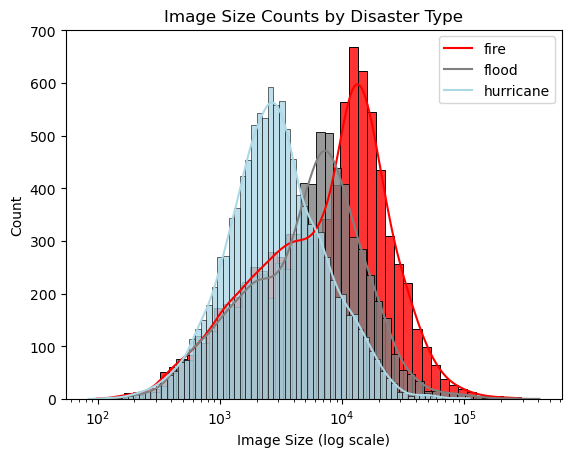

In [6]:
def get_width(row):
    return row.shape[0]


def get_height(row):
    return row.shape[1]


train_df["width"] = train_df["image"].apply(get_width)
train_df["height"] = train_df["image"].apply(get_height)
train_df["image_size"] = train_df["width"] * train_df["height"]


df = train_df
alpha = 0.8
sns.histplot(
    data=df[df["type"] == "fire"],
    x="image_size",
    kde=True,
    stat="count",
    label="image size",
    log_scale=True,
    color="red",
    alpha=alpha,
)
sns.histplot(
    data=df[df["type"] == "flood"],
    x="image_size",
    kde=True,
    stat="count",
    label="image size",
    log_scale=True,
    color="grey",
    alpha=alpha,
)
sns.histplot(
    data=df[df["type"] == "hurricane"],
    x="image_size",
    kde=True,
    stat="count",
    label="image size",
    log_scale=True,
    color="lightblue",
    alpha=alpha,
)
plt.legend(labels=["fire", "flood", "hurricane"])
plt.xlabel("Image Size (log scale)")
plt.title("Image Size Counts by Disaster Type")
plt.savefig(f"{figure_path}/eda_image_size_hist.png", dpi=96)

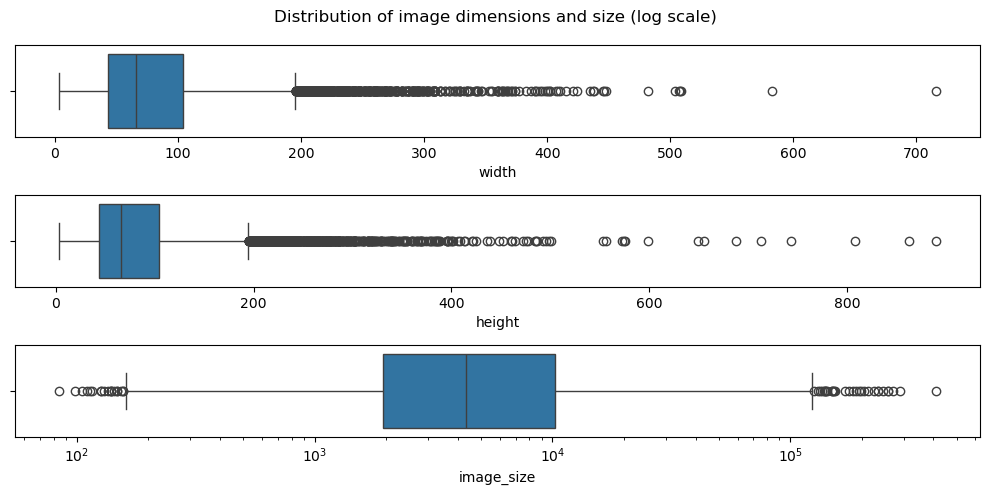

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 1, figsize=(10, 5))
sns.boxplot(data=df, x="width", ax=ax[0], log_scale=False)
sns.boxplot(data=df, x="height", ax=ax[1], log_scale=False)
sns.boxplot(data=df, x="image_size", ax=ax[2], log_scale=True)

plt.suptitle("Distribution of image dimensions and size (log scale)")
plt.subplots_adjust(wspace=0.3)
plt.tight_layout()
plt.savefig(f"{figure_path}/eda_image_size_box.png", dpi=96)

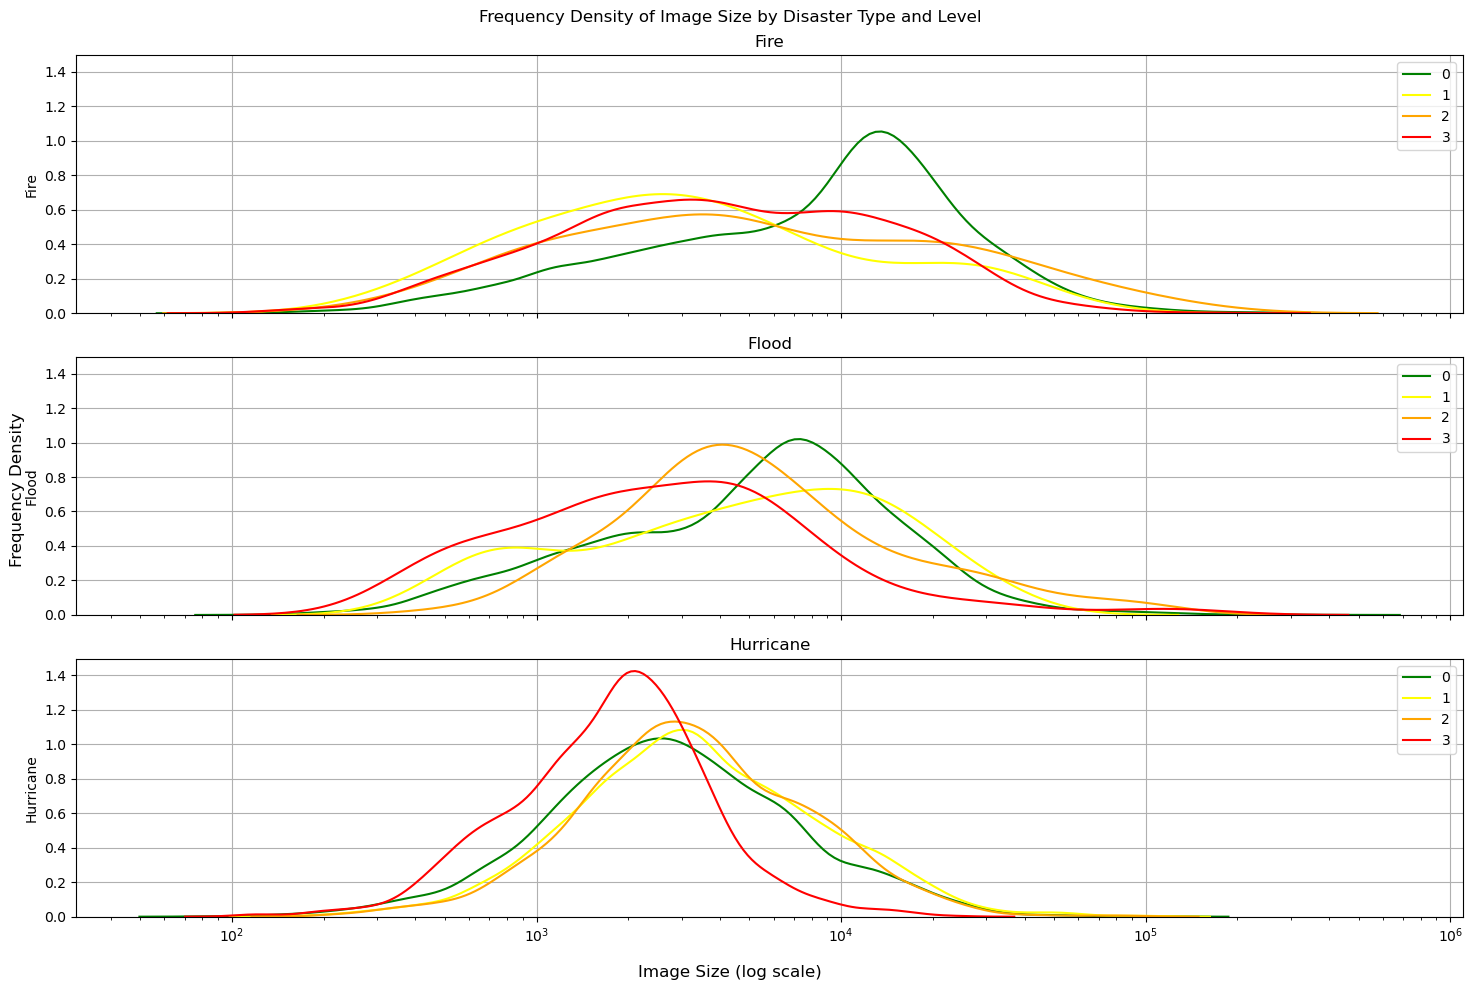

In [8]:
sns.set_palette("bright")  # This only set the kde curve color...
color_dict = {0: "green", 1: "yellow", 2: "orange", 3: "red"}

alpha = 1
# plt.figure(figsize=(15, 10))
share = "all"
fig, ax = plt.subplots(3, 1, sharex=share, sharey=share, figsize=(15, 10))
for axi, type in enumerate(df["type"].unique()):
    # plt.subplot(3, 1, axi+1, sharex='all', sharey='all')
    for level in range(4):
        # sns.histplot(data=df[(df['type']== type) & (df.label== level)], x='image_size', kde=True, stat="count", label=f'{level}', log_scale=True, color = color_dict[level], alpha=alpha)
        sns.kdeplot(
            data=df[(df["type"] == type) & (df.label == level)],
            x="image_size",
            label=f"{level}",
            log_scale=True,
            color=color_dict[level],
            alpha=alpha,
            bw_adjust=0.9,
            ax=ax[axi],
        )
    ax[axi].legend()
    ax[axi].set_xlabel("")
    ax[axi].set_ylabel(f"{type.title()}")
    ax[axi].set_title(f"{type.title()}")
    ax[axi].grid()
    # plt.gca().set_yscale('log')

fig.supxlabel("Image Size (log scale)")
fig.supylabel("Frequency Density")
plt.suptitle("Frequency Density of Image Size by Disaster Type and Level")
plt.tight_layout()

plt.savefig(f"{figure_path}/eda_image_size_kde_bylevel.png", dpi=96)

### Color Distribution

In [9]:
%%time


def avg_color(img):
    return np.mean(img, axis=(0, 1))


df["avg_color"] = df["image"].apply(avg_color)
df["Red"] = df["avg_color"].apply(lambda x: x[0])
df["Green"] = df["avg_color"].apply(lambda x: x[1])
df["Blue"] = df["avg_color"].apply(lambda x: x[2])

melt_df = pd.melt(
    df,
    id_vars=["type", "label"],
    value_vars=["Red", "Green", "Blue"],
    var_name="color_channel",
    value_name="color_val",
)

CPU times: user 4.98 s, sys: 3.91 ms, total: 4.98 s
Wall time: 5 s


In [10]:
melt_df.head()

,type,label,color_channel,color_val
0,fire,0,Red,110.409046
1,fire,0,Red,70.399918
2,fire,0,Red,97.319162
3,fire,0,Red,96.571841
4,fire,0,Red,76.582532


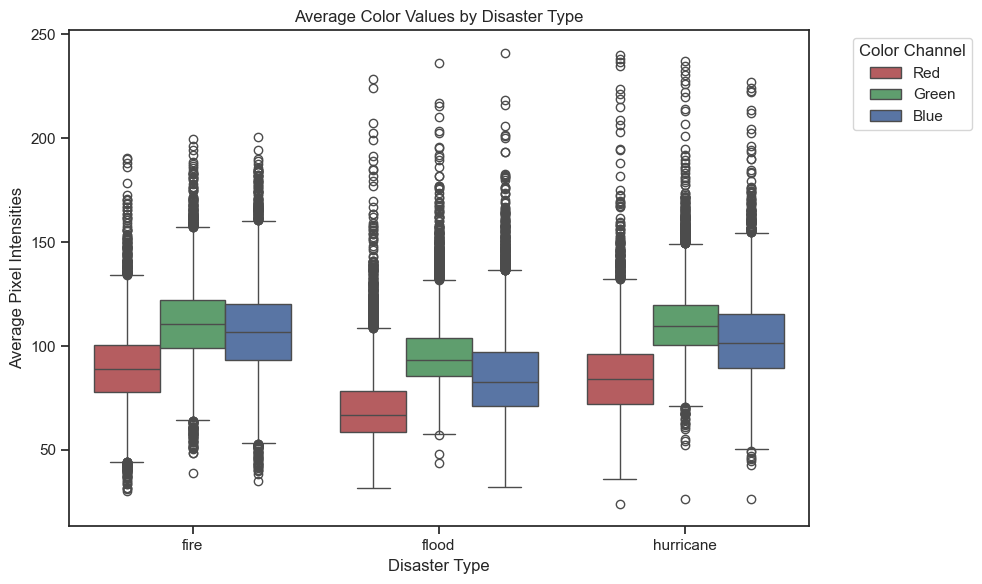

In [11]:
sns.set_theme(style="ticks")
plt.figure(figsize=(10, 6))
sns.boxplot(
    melt_df,
    x="type",
    y="color_val",
    hue="color_channel",
    palette=["r", "g", "b"],
)
plt.xlabel("Disaster Type")
plt.ylabel("Average Pixel Intensities")
plt.title("Average Color Values by Disaster Type")
plt.legend(
    title="Color Channel", bbox_to_anchor=(1.05, 1), loc="upper left"
)
plt.tight_layout()
plt.savefig(f"{figure_path}/eda_avg_pixel_bar.png", dpi=96)
plt.show()

In [12]:
%%time
df["std_color"] = df["image"].apply(
    lambda x: np.std(np.array(x), axis=(0, 1))
)

df["Red"] = df["std_color"].apply(lambda x: x[0])
df["Green"] = df["std_color"].apply(lambda x: x[1])
df["Blue"] = df["std_color"].apply(lambda x: x[2])

var_df = pd.melt(
    df,
    id_vars=["type", "label"],
    value_vars=["Red", "Green", "Blue"],
    var_name="color_channel",
    value_name="std_pixel",
)

var_df.head()

CPU times: user 12 s, sys: 8.22 ms, total: 12.1 s
Wall time: 12.1 s


,type,label,color_channel,std_pixel
0,fire,0,Red,51.128969
1,fire,0,Red,22.793470
2,fire,0,Red,42.198429
3,fire,0,Red,32.584155
4,fire,0,Red,26.867641


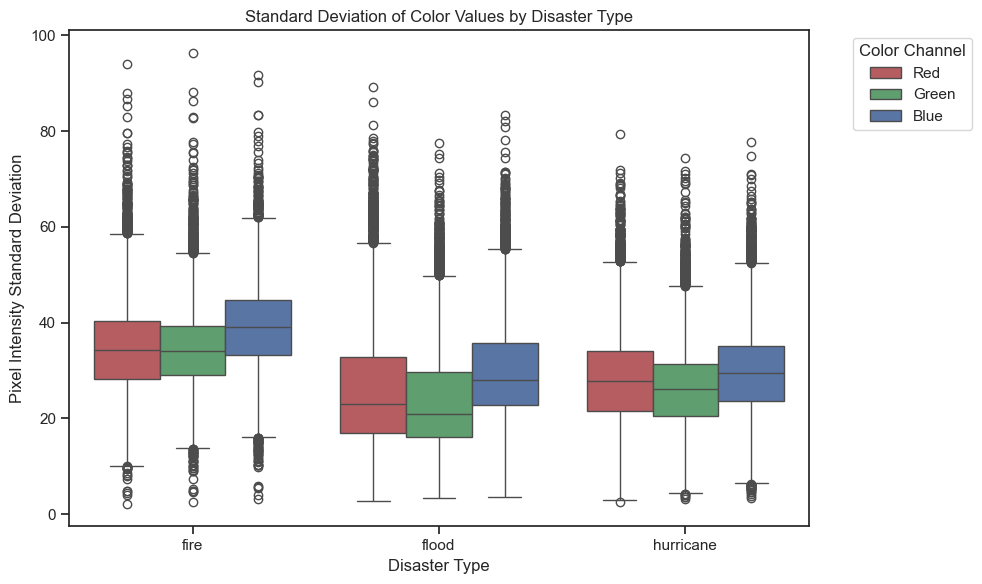

In [13]:
sns.set_theme(style="ticks")
plt.figure(figsize=(10, 6))
sns.boxplot(
    var_df,
    x="type",
    y="std_pixel",
    hue="color_channel",
    palette=["r", "g", "b"],
)
plt.xlabel("Disaster Type")
plt.ylabel("Pixel Intensity Standard Deviation")
plt.title("Standard Deviation of Color Values by Disaster Type")
plt.legend(
    title="Color Channel", bbox_to_anchor=(1.05, 1), loc="upper left"
)
plt.tight_layout()
plt.savefig(f"{figure_path}/eda_std_pixel_bar.png", dpi=96)
plt.show()

In [14]:
# create "heatmap" of average pixel value for each category
heat_array = []
label = []
dis_type = ["hurricane", "flood", "fire"]
dmg_labels = ["None", "Minor", "Major", "Destroyed"]
for dtype in dis_type:
    for i in range(4):
        type_vals = (
            df[(df["type"] == dtype) & (df["label"] == i)]["avg_color"]
            .sample(n=16)
            .values
        )
        type_vals = np.array([np.array(i) for i in type_vals]).reshape(
            (16, 3)
        )
        heat_array.append(type_vals)
        label.append(dmg_labels[i])
heat_array = np.array(heat_array)
heat_array = heat_array.reshape((12, 16, 3))
print(np.array(heat_array).shape)

(12, 16, 3)


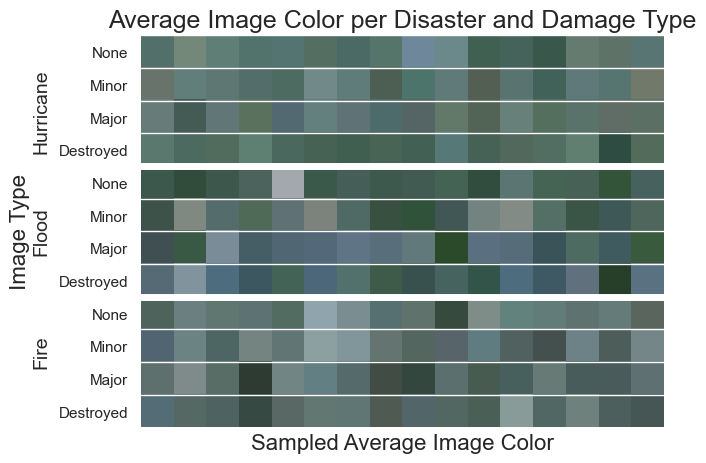

In [15]:
sns.set_style("white")
fig, ax = plt.subplots()
ax.imshow(heat_array.astype(int))

for border_coord in range(12):
    if border_coord == 4 or border_coord == 8:
        plt.axhline(border_coord - 0.5, color="white", linewidth=5)
    else:
        plt.axhline(border_coord - 0.5, color="white", linewidth=1)

ax.axes.xaxis.set_ticks([])
ax.set_yticks(np.arange(12), label)
ax.set_frame_on(False)

plt.xlabel("Sampled Average Image Color", fontsize=16)
plt.title("Average Image Color per Disaster and Damage Type", fontsize=18)
fig.text(
    -0.05, 0.5, "Image Type", va="center", rotation="vertical", fontsize=16
)
fig.text(
    -0.015, 0.25, "Fire", va="center", rotation="vertical", fontsize=14
)
fig.text(
    -0.015, 0.5, "Flood", va="center", rotation="vertical", fontsize=14
)
fig.text(
    -0.015,
    0.75,
    "Hurricane",
    va="center",
    rotation="vertical",
    fontsize=14,
)

plt.tight_layout()
plt.savefig(f"{figure_path}/eda_avg_color_swatch.png", dpi=96)
plt.show()

## Task A

### Feature Engineering (Task A)

In [16]:
# Select Dataset for Disaster Type Classification
train_type_df = train_df[
    ((train_df.type == "fire") | (train_df.type == "flood"))
]  # & (train_df.label != 0)]
test_type_df = test_df[
    ((test_df.type == "fire") | (test_df.type == "flood"))
]  # & (test_df.label != 0)]
show_balance(train_type_df)

# Encode labels
def encode_label(type_df):
    type_df = type_df.copy()
    type_df["old_label"] = type_df["label"]
    type_df["label"] = (
        type_df[["type", "old_label"]]
        .apply(
            lambda df: (df["old_label"] + 1)
            if df["type"] == "fire"
            else -(df["old_label"]),
            axis=1,
        )
        .astype("int")
        + 3
    )
    return type_df


train_type_df = encode_label(train_type_df)

show_balance(train_type_df)
train_type_df.shape, test_type_df.shape

type   label
fire   0        7204
       3        1064
       1          69
       2          43
flood  0        6734
       1         114
       2          97
       3          59
Name: count, dtype: int64

type   label
fire   4        7204
       7        1064
       5          69
       6          43
flood  3        6734
       2         114
       1          97
       0          59
Name: count, dtype: int64

((15384, 13), (3847, 3))

In [17]:
# Verify class labels
unique_labels = np.unique(train_type_df["label"])
expected_indices = np.arange(8)  # Indices for 8 classes (0 to 7)

if not np.array_equal(unique_labels, expected_indices):
    print(
        "Class labels do not match expected indices. Please verify your labels."
    )

In [18]:
unique_labels, expected_indices

(array([0, 1, 2, 3, 4, 5, 6, 7]), array([0, 1, 2, 3, 4, 5, 6, 7]))

### Model PCA (Task A)

In [19]:
def resize_images(df, size=(SIZE, SIZE)):
    resized_images = []
    for i in range(len(df)):
        img = df['image'].iloc[i]
        #img_resized = cv2.resize(img, size)/255.0  # for positive definateness
        img_resized = cv2.resize(img, size, interpolation= cv2.INTER_LINEAR)/255.0
        img_resized = img_resized.flatten() # Flatten the images
        resized_images.append(img_resized)
    return np.array(resized_images)

In [20]:
import cv2
import numpy as np
from skimage import feature

def process_images(df, size=(SIZE, SIZE)):
    processed_images = []
    for i in range(len(df)):
        img = df['image'].iloc[i]

        # Resize
        img_resized = cv2.resize(img, size)
        
        # Calculate average color
        avg_color = np.mean(img_resized, axis=(0, 1))
        
        # Calculate color variance
        color_variance = np.var(img_resized, axis=(0, 1))
        
        # Convert image to grayscale for LBP
        img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
        
        # Calculate Local Binary Pattern (LBP)
        radius = 3
        n_points = 8 * radius
        lbp = feature.local_binary_pattern(img_gray, n_points, radius, method="uniform")
        lbp = lbp.flatten()
        
        #processed_images.append([avg_color, color_variance, lbp])
        
        # Flatten the features into a single numpy array
        features = np.concatenate([avg_color, color_variance, lbp])
        
        processed_images.append(features)
        
    return processed_images

In [21]:
%%time
from sklearn.model_selection import train_test_split

# Prepare data
SIZE_PCA = 10 # Let's keep this small as it performs poorly regardless of size.

m_train_df, m_val_df = train_test_split(
    df, test_size=0.2, stratify=df["label"], random_state=42
)

X_train = resize_images(m_train_df, size=(SIZE_PCA,SIZE_PCA))  # use image resizing and scaling
#X_train = process_images(m_train_df, size=(SIZE_PCA,SIZE_PCA))  # use image processing
Y_train = m_train_df["label"].astype(int)

X_val = resize_images(m_val_df, size=(SIZE_PCA,SIZE_PCA))  # use image resizing and scaling
#X_val = process_images(m_val_df, size=(SIZE_PCA,SIZE_PCA))  # use image processing
Y_val = m_val_df["label"].astype(int)

CPU times: user 1.23 s, sys: 67.1 ms, total: 1.3 s
Wall time: 1.36 s


In [22]:
X_train[0].shape

(300,)

#### SVD w/SVM


This bit takes a wihle so we'll comment out this section and note the results.

```
Precision:  0.389948121819261
Recall:  0.6244582626719427
F1 Score:  0.4800962028754943
Accuracy:  0.6244582626719427
```

In [23]:
"""
from sklearn.decomposition import TruncatedSVD
from sklearn import datasets
from sklearn import svm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Perform SVD on the training set
svd = TruncatedSVD(n_components=30, n_iter=3, random_state=42)
X_train_svd = svd.fit_transform(X_train)

# Transform the validation set
X_val_svd = svd.transform(X_val)

# Create a SVM classifier
clf = svm.SVC(gamma=0.001, C=100.)

# Train the model using the training sets
clf.fit(X_train_svd, Y_train)

# Predict the response for validation dataset
Y_pred = clf.predict(X_val_svd)

# Print the model prediction statistics
print("Precision: ", precision_score(Y_val, Y_pred, average='weighted'))
print("Recall: ", recall_score(Y_val, Y_pred, average='weighted'))
print("F1 Score: ", f1_score(Y_val, Y_pred, average='weighted'))
print("Accuracy: ", accuracy_score(Y_val, Y_pred))
""";

#### PCA w/LR

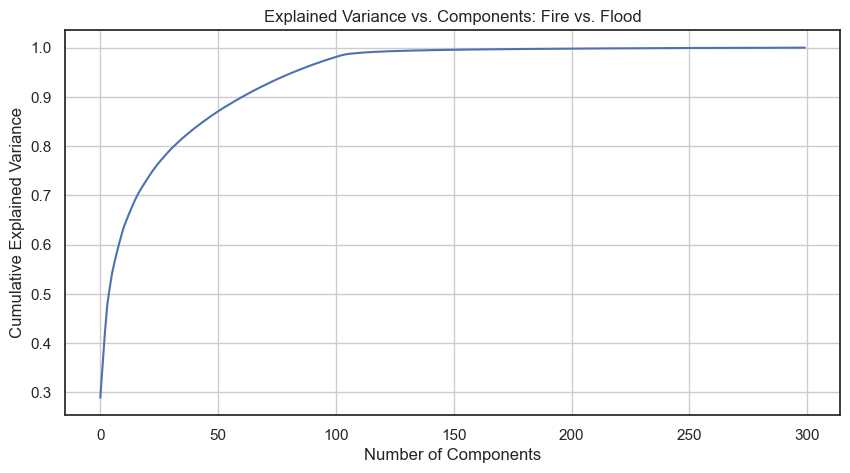

CPU times: user 3.77 s, sys: 806 ms, total: 4.58 s
Wall time: 1.99 s


In [24]:
%%time
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
import matplotlib.pyplot as plt

# Apply PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train)

# Plot the explained variance ratio
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()

plt.title("Explained Variance vs. Components: Fire vs. Flood")
plt.savefig(f"{figure_path}/model_eval_task_a_pca_variance.png", dpi=300)
plt.show()

In [25]:
%%time

# Fit a classifier on the PCA transformed data
clf= []
clf = LogisticRegression(max_iter=2000)
clf.fit(X_train_pca, Y_train)

# Transform the test data
X_val_pca = pca.transform(X_val)

# Make prediction
Y_pred = clf.predict(X_val_pca)

# Print the model prediction statistics
print("Precision: ", precision_score(Y_val, Y_pred, average='weighted'))
print("Recall: ", recall_score(Y_val, Y_pred, average='weighted'))
print("F1 Score: ", f1_score(Y_val, Y_pred, average='weighted'))
print("Accuracy: ", accuracy_score(Y_val, Y_pred))

Precision:  0.4751212155846616
Recall:  0.6095722630488035
F1 Score:  0.5039991309544488
Accuracy:  0.6095722630488035
CPU times: user 10.7 s, sys: 2.63 s, total: 13.3 s
Wall time: 3.83 s


#### LogReg

In [26]:
%%time

# Fit a classifier on the non-transformed data
clf= []
clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, Y_train)

# Make prediction
Y_pred = clf.predict(X_val)

# Print the model prediction statistics
print("Precision: ", precision_score(Y_val, Y_pred, average='weighted'))
print("Recall: ", recall_score(Y_val, Y_pred, average='weighted'))
print("F1 Score: ", f1_score(Y_val, Y_pred, average='weighted'))
print("Accuracy: ", accuracy_score(Y_val, Y_pred))

Precision:  0.4746560383651242
Recall:  0.609383832673827
F1 Score:  0.5038646725923501
Accuracy:  0.609383832673827
CPU times: user 34.7 s, sys: 7.78 s, total: 42.5 s
Wall time: 11.7 s


#### Observations

We attempted to enhance our models with additional feature engineering, such as incorporating average color, color variance, and image contrast, and by applying image processing techniques such as local binary pattern transformation.  None of these method produce well preformaing and generalizable models.

### Model CNN (Task A)

We utilize a pretrained vgg16 network to create bottleneck features then a simple fully-connected model for classification.
This choice was make to accelerate testing of various classification models but reuse of the bottleneck features can take a rather long time (~1.5hrs) to create, while the classification models take only few seconds to train and test.

see also: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [27]:
train_type_df.columns

Index(['index', 'type', 'image', 'label', 'width', 'height', 'image_size',
       'avg_color', 'Red', 'Green', 'Blue', 'std_color', 'old_label'],
      dtype='object')

In [28]:
from tensorflow.keras import backend

backend.clear_session()  # clear model

In [29]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D
from sklearn.model_selection import train_test_split

# from sklearn.utils import class_weight
from sklearn.utils import compute_class_weight


SIZE = 120  # Set image size

# Load Our DataFrame
df = train_type_df

# Note that 'image' column contains RGB images as numpy arrays
# and 'label' column contains values (-3, -2, -1, 0, 1, 2, 3),
# Nope... [0,1,2,3,4,5,6,7], where >3.5 is fire

# Split data into training and validation sets
m_train_df, m_val_df = train_test_split(
    df, test_size=0.2, stratify=df["label"], random_state=42
)

# Load VGG16 model with pre-trained weights (excluding top layers)
vgg16 = VGG16(
    weights="imagenet", include_top=False, input_shape=(SIZE, SIZE, 3)
)

# Extract bottleneck features for training data
def extract_bottleneck_features(dataframe):
    features = []
    for img_array in tqdm(dataframe["image"]):
        img_array = tf.image.resize(
            img_array, (SIZE, SIZE)
        )  # Resize to VGG16 input size
        img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
        bottleneck_feature = vgg16.predict(
            np.expand_dims(img_array, axis=0), verbose=0
        )
        features.append(bottleneck_feature.flatten())
    return np.array(features)


train_features, val_features = [], []
if (
    os.path.exists(data_dir)
    & os.path.isfile(f"{data_dir}/task_A_train_features.npy")
    & os.path.isfile(f"{data_dir}/task_A_test_features.npy")
    & os.path.isfile(f"{data_dir}/task_A_val_features.npy")
):
    train_features = np.load(f"{data_dir}/task_A_train_features.npy")
    test_features = np.load(f"{data_dir}/task_A_test_features.npy")
    val_features = np.load(f"{data_dir}/task_A_val_features.npy")
else:
    train_features = extract_bottleneck_features(m_train_df)
    test_features = extract_bottleneck_features(test_type_df)
    val_features = extract_bottleneck_features(m_val_df)
    np.save(f"{data_dir}/task_A_train_features.npy", train_features)
    np.save(f"{data_dir}/task_A_test_features.npy", test_features)
    np.save(f"{data_dir}/task_A_val_features.npy", val_features)

# Create a simple fully-connected model
model = Sequential()
model.add(Flatten(input_shape=train_features.shape[1:]))
model.add(Dense(128, activation="relu")) # More dense
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(8, activation="softmax"))  # 8 classes

# Compile the model
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# Calculate class weights for imbalanced labels
train_classes = m_train_df["label"]
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_classes),
    y=train_classes,
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Save the model
model_name = "task_A_vgg16_model_dropout_more_dense"
model_0, history_0, notes_0 = load_model_data(model_name, path=data_dir)
if model_0 != None:
    model, model_history, notes = model_0, history_0, notes_0
else:
    # Train the model
    model_history = model.fit(
        train_features,
        m_train_df["label"],
        validation_data=(val_features, m_val_df["label"]),
        epochs=15,
        batch_size=128,
        class_weight=class_weights_dict,
    )
    # Save, one and done.
    save_model_data(
        model_name,
        model,
        model_history,
        "trained on weighted labels",
        path=data_dir,
    )

../data/models/task_A_vgg16_model_dropout_more_dense
../data/models/task_A_vgg16_model_dropout_more_dense/history.pkl
Gherkin injested.


#### Model Summary (Task A)

In [30]:
vgg16.summary()
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 120, 120, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 120, 120, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 60, 60, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 60, 60, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 60, 60, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 30, 30, 128)       0     

In [31]:
# Save model and feature weights
FREEZE = False
if FREEZE:
    model_name = "task_A_vgg16_model"
    save_model_data(
        model_name,
        model,
        model_history,
        "trained on weighted labels",
        path=data_dir,
    )
    np.save(f"{data_dir}/task_A_train_features.npy", train_features)
    np.save(f"{data_dir}/task_A_test_features.npy", test_features)
    np.save(f"{data_dir}/task_A_val_features.npy", val_features)

# train_features = np.load(f'{data_dir}/train_features.npy')
# val_features = np.load(f'{data_dir}/val_features.npy')
train_features.shape, val_features.shape

((12307, 4608), (3077, 4608))

#### Model Evaluation (Task A)

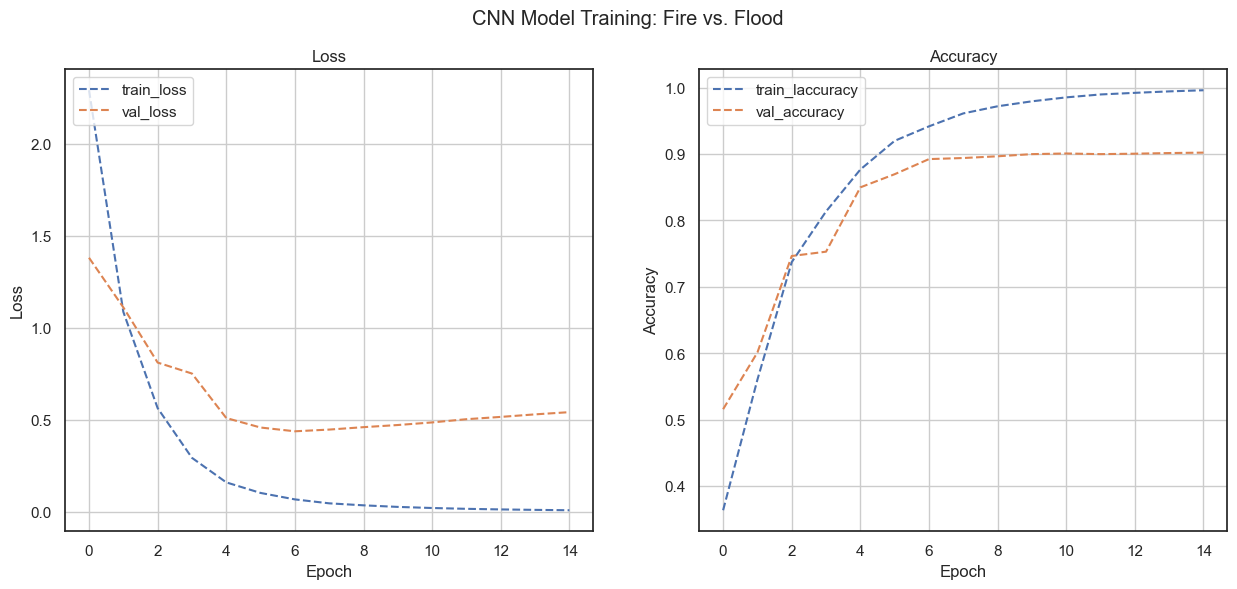

In [32]:
def plot_loss(History):
    history = History.history
    N = len(history["loss"])
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(0, N), history["loss"], label="train_loss", ls="--")
    plt.plot(
        np.arange(0, N), history["val_loss"], label="val_loss", ls="--"
    )
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper left")
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(
        np.arange(0, N),
        history["accuracy"],
        label="train_laccuracy",
        ls="--",
    )
    plt.plot(
        np.arange(0, N),
        history["val_accuracy"],
        label="val_accuracy",
        ls="--",
    )
    # plt.yscale('log')
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")
    plt.grid()


plot_loss(model_history)
plt.suptitle("CNN Model Training: Fire vs. Flood")
plt.savefig(f"{figure_path}/model_eval_task_a_cnn_training.png", dpi=300)

In [33]:
# Use Custom Activation
def custom_activation(y):
    return np.where(y > 3.5, 1, 0)

In [34]:
# Validate model accuracy
Y_pred = model.predict(val_features)
# Y_pred = model.predict(train_features)
Y_pred = custom_activation(np.argmax(Y_pred, axis=1))
np.sum(Y_pred, axis=0) / len(Y_pred)
Y_actual = custom_activation(m_val_df["label"].to_numpy())
sum(Y_pred == Y_actual) / len(Y_actual)

97/97 [==============================] - 1s 4ms/step


0.9629509262268443

              precision    recall  f1-score   support

           0     0.9567    0.9622    0.9594      1401
           1     0.9682    0.9636    0.9659      1676

    accuracy                         0.9630      3077
   macro avg     0.9625    0.9629    0.9627      3077
weighted avg     0.9630    0.9630    0.9630      3077



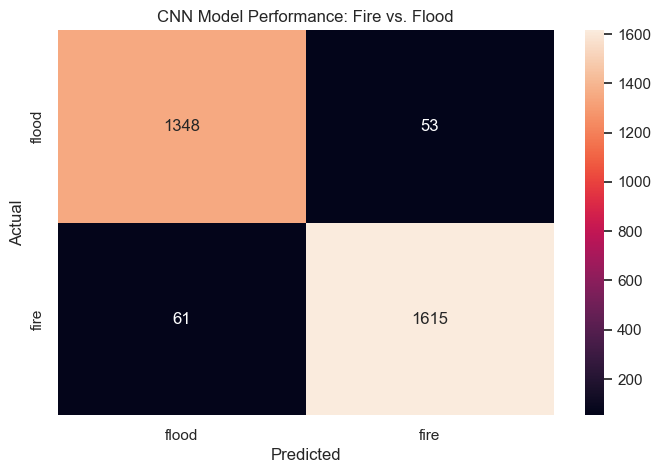

In [35]:
# Evaluate our model based on precision, recall, and f1-score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Printing the classification report
print(classification_report(Y_actual, Y_pred, digits=4))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(Y_actual, Y_pred)
plt.figure(figsize=(8, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt=".0f",
    xticklabels=["flood", "fire"],
    yticklabels=["flood", "fire"],
)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("CNN Model Performance: Fire vs. Flood")
plt.savefig(f"{figure_path}/model_eval_task_a_cnn_confusion.png", dpi=300)
plt.show()

#### Prediction (Task A)

In [36]:
# Train on all data...
combined_features = np.concatenate((train_features, val_features), axis=0)
combined_targets = pd.concat([m_train_df["label"], m_val_df["label"]])
combined_features.shape, combined_targets.shape

((15384, 4608), (15384,))

In [37]:
# Calculate class weights for imbalanced labels
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(combined_targets),
    y=train_classes,
)

class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

In [38]:
backend.clear_session()  # clear model
model_history = model.fit(
    combined_features,
    combined_targets.astype(float),
    epochs=15,
    batch_size=128,
    class_weight=class_weights_dict,
)

Epoch 1/15
121/121 [==============================] - 3s 18ms/step - loss: 1.0682 - accuracy: 0.7502
Epoch 2/15
121/121 [==============================] - 2s 18ms/step - loss: 0.5589 - accuracy: 0.7903
Epoch 3/15
121/121 [==============================] - 2s 19ms/step - loss: 0.4173 - accuracy: 0.8419
Epoch 4/15
121/121 [==============================] - 2s 18ms/step - loss: 0.1484 - accuracy: 0.9070
Epoch 5/15
121/121 [==============================] - 2s 19ms/step - loss: 0.0628 - accuracy: 0.9494
Epoch 6/15
121/121 [==============================] - 2s 18ms/step - loss: 0.0447 - accuracy: 0.9702
Epoch 7/15
121/121 [==============================] - 2s 19ms/step - loss: 0.0204 - accuracy: 0.9827
Epoch 8/15
121/121 [==============================] - 2s 18ms/step - loss: 0.0123 - accuracy: 0.9908
Epoch 9/15
121/121 [==============================] - 2s 19ms/step - loss: 0.0086 - accuracy: 0.9944
Epoch 10/15
121/121 [==============================] - 2s 18ms/step - loss: 0.0062 - accura

In [39]:
# Make prediction based on test data
Y_pred = model.predict(test_features)

prediction = custom_activation(np.argmax(Y_pred, axis=1))
Y_pred_out = pd.DataFrame(prediction, columns=["pred"])
Y_pred_out.to_csv(
    f"{data_dir}/test_images_flooding-fire_predictions.csv", index=False
)

121/121 [==============================] - 0s 4ms/step


#### Predict Using Augmented Data

In [40]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_smote, Y_smote = smote.fit_resample(combined_features, combined_targets.astype(int))

In [41]:
Y_smote.shape, combined_targets.shape

((57632,), (15384,))

In [42]:
# clear model
backend.clear_session()

# recompile
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

#fit
model_history = model.fit(
    X_smote,
    Y_smote,
    epochs=11,
    batch_size=128,
)

2024-05-09 18:11:11.391703: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1062273024 exceeds 10% of free system memory.


Epoch 1/11
451/451 [==============================] - 9s 18ms/step - loss: 0.0491 - accuracy: 0.9853
Epoch 2/11
451/451 [==============================] - 9s 21ms/step - loss: 0.0230 - accuracy: 0.9930
Epoch 3/11
451/451 [==============================] - 8s 18ms/step - loss: 0.0165 - accuracy: 0.9950
Epoch 4/11
451/451 [==============================] - 8s 18ms/step - loss: 0.0165 - accuracy: 0.9952
Epoch 5/11
451/451 [==============================] - 9s 19ms/step - loss: 0.0115 - accuracy: 0.9969
Epoch 6/11
451/451 [==============================] - 8s 17ms/step - loss: 0.0198 - accuracy: 0.9949
Epoch 7/11
451/451 [==============================] - 8s 18ms/step - loss: 0.0081 - accuracy: 0.9975
Epoch 8/11
451/451 [==============================] - 8s 17ms/step - loss: 0.0090 - accuracy: 0.9975
Epoch 9/11
451/451 [==============================] - 7s 16ms/step - loss: 0.0123 - accuracy: 0.9968
Epoch 10/11
451/451 [==============================] - 8s 17ms/step - loss: 0.0100 - accura

In [43]:
# Make prediction based on test data
Y_pred = model.predict(test_features)

prediction = custom_activation(np.argmax(Y_pred, axis=1))
Y_pred_out = pd.DataFrame(prediction, columns=["pred"])
Y_pred_out.to_csv(
    f"{data_dir}/test_images_flooding-fire_predictions.csv", index=False
)

121/121 [==============================] - 1s 4ms/step


## Task B

### Feature Engineering (Task B)

In [44]:
# Select Dataset for Disaster Leve Classification
train_level_df = train_df[(train_df.type == "hurricane")]
test_level_df = test_df[(test_df.type == "hurricane")]
show_balance(train_level_df)

type       label
hurricane  1        5236
           0        2631
           3        1740
           2        1544
Name: count, dtype: int64

In [45]:
train_level_df.type.unique()

array(['hurricane'], dtype=object)

In [46]:
train_level_df.columns

Index(['index', 'type', 'image', 'label', 'width', 'height', 'image_size',
       'avg_color', 'Red', 'Green', 'Blue', 'std_color'],
      dtype='object')

### Model CNN (TaskB)

In [47]:
backend.clear_session()  # clear model

In [48]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight

# Set image size
SIZE = 120  

# Load Our DataFrame
df = train_level_df

# Note that 'image' column contains RGB images as numpy arrays
# and 'label' column contains values (0,1,2,3)

# Split data into training and validation sets
m_train_df, m_val_df = train_test_split(
    df, test_size=0.2, stratify=df["label"], random_state=42
)

# Load VGG16 model with pre-trained weights (excluding top layers)
vgg16 = VGG16(
    weights="imagenet", include_top=False, input_shape=(SIZE, SIZE, 3)
)

# Extract bottleneck features for training data
def extract_bottleneck_features(dataframe):
    features = []
    for img_array in tqdm(dataframe["image"]):
        img_array = tf.image.resize(
            img_array, (SIZE, SIZE)
        )  # Resize to VGG16 input size
        img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
        bottleneck_feature = vgg16.predict(
            np.expand_dims(img_array, axis=0), verbose=0
        )
        features.append(bottleneck_feature.flatten())
    return np.array(features)


train_features, val_features = [], []
if (
    os.path.exists(data_dir)
    & os.path.isfile(f"{data_dir}/task_B_train_features.npy")
    & os.path.isfile(f"{data_dir}/task_B_test_features.npy")
    & os.path.isfile(f"{data_dir}/task_B_val_features.npy")
):
    train_features = np.load(f"{data_dir}/task_B_train_features.npy")
    test_features = np.load(f"{data_dir}/task_B_test_features.npy")
    val_features = np.load(f"{data_dir}/task_B_val_features.npy")
else:  
    m_test_df = test_level_df
    train_features = extract_bottleneck_features(m_train_df)
    test_features = extract_bottleneck_features(m_test_df)
    val_features = extract_bottleneck_features(m_val_df)
    np.save(f"{data_dir}/task_B_train_features.npy", train_features)
    np.save(f"{data_dir}/task_B_test_features.npy", test_features)
    np.save(f"{data_dir}/task_B_val_features.npy", val_features)

# Create a simple fully-connected model
model = Sequential()
model.add(Flatten(input_shape=train_features.shape[1:]))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))  # 4 classes

# Compile the model
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# Calculate class weights for imbalanced labels
train_classes = m_train_df["label"]
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_classes),
    y=train_classes,
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Save the model
model_name = "task_B_vgg16_model_dropout"
model_0, history_0, notes_0 = load_model_data(model_name, path=data_dir)
if model_0 != None:
    model, model_history, notes = model_0, history_0, notes_0
else:
    # Train the model
    model_history = model.fit(
        train_features,
        m_train_df["label"].astype(float),
        validation_data=(val_features, m_val_df["label"].astype(float)),
        epochs=11,
        batch_size=128,
        class_weight=class_weights_dict,
    )

    # Save, one and done.
    save_model_data(
        model_name,
        model,
        model_history,
        "trained on weighted labels",
        path=data_dir,
    )

../data/models/task_B_vgg16_model_dropout
../data/models/task_B_vgg16_model_dropout/history.pkl
Gherkin injested.


#### Model Summary (Task B)

In [49]:
vgg16.summary()
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 120, 120, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 120, 120, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 60, 60, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 60, 60, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 60, 60, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 30, 30, 128)       0     

#### Model Evaluation (Task B)

In [50]:
def custom_activation(y):
    return np.argmax(y, axis=1)

In [51]:
Y_pred = model.predict(val_features)
Y_pred = custom_activation(Y_pred)
Y_actual = m_val_df["label"].astype(int).to_numpy()

70/70 [==============================] - 0s 4ms/step


In [52]:
sum(Y_pred == Y_actual) / len(Y_actual)

0.5535634244733303

In [53]:
class_weights_dict

{0: 1.0593824228028503,
 1: 0.5324737344794651,
 2: 1.805668016194332,
 3: 1.6020114942528736}

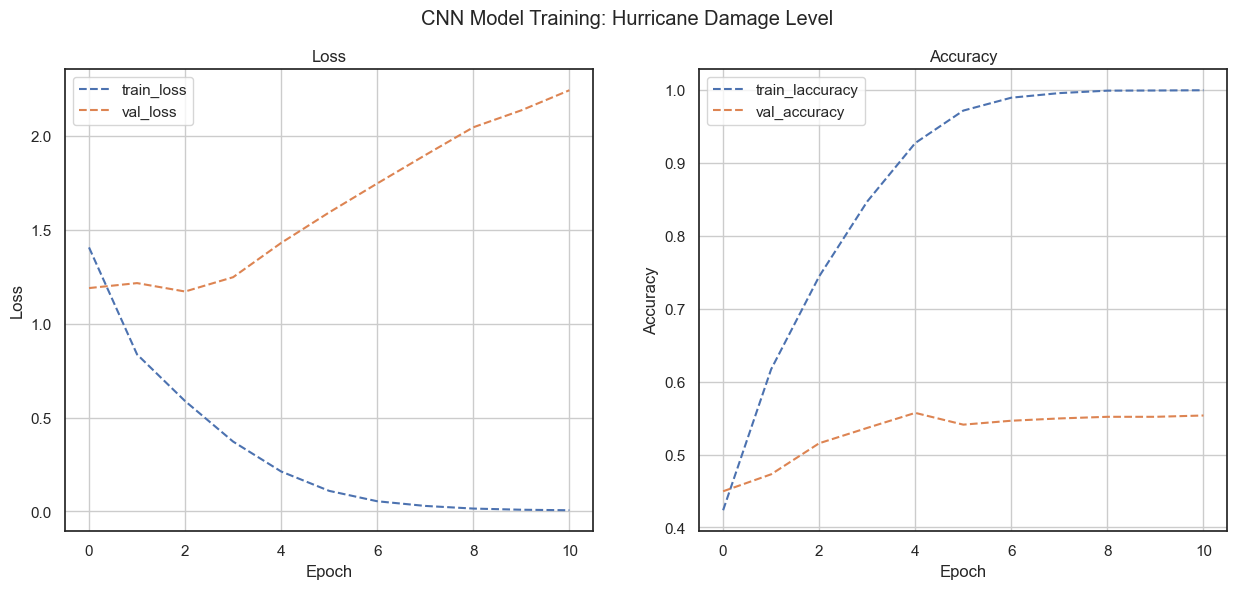

In [54]:
plot_loss(model_history)
plt.suptitle("CNN Model Training: Hurricane Damage Level")
plt.savefig(f"{figure_path}/model_eval_task_b_cnn_training.png", dpi=300)

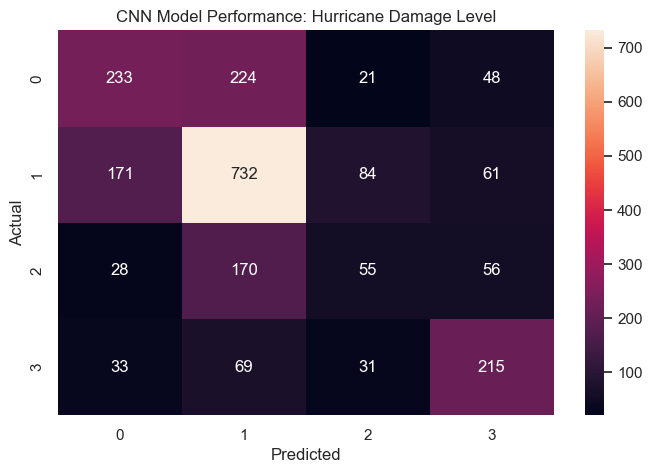

              precision    recall  f1-score   support

           0       0.50      0.44      0.47       526
           1       0.61      0.70      0.65      1048
           2       0.29      0.18      0.22       309
           3       0.57      0.62      0.59       348

    accuracy                           0.55      2231
   macro avg       0.49      0.48      0.48      2231
weighted avg       0.53      0.55      0.54      2231



In [55]:
from sklearn.metrics import classification_report
import numpy as np

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(Y_actual, Y_pred)
plt.figure(figsize=(8, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt=".0f",
    xticklabels=["0", "1", "2", "3"],
    yticklabels=["0", "1", "2", "3"],
)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("CNN Model Performance: Hurricane Damage Level")
plt.savefig(f"{figure_path}/model_eval_task_b_cnn_confusion.png", dpi=300)
plt.show()

print(
    classification_report(
        Y_actual, Y_pred, target_names=["0", "1", "2", "3"]
    )
)

#### Prediction (Task B)

In [56]:
# Train on all data...
combined_features = np.concatenate((train_features, val_features), axis=0)
combined_targets = pd.concat([m_train_df["label"], m_val_df["label"]])

combined_features.shape, combined_targets.shape

((11151, 4608), (11151,))

In [57]:
# Calculate class weights for imbalanced labels
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(combined_targets),
    y=train_classes,
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

In [58]:
backend.clear_session()  # clear model

In [59]:
model_history = model.fit(
    combined_features,
    combined_targets.astype(float),
    epochs=11,
    batch_size=128,
    class_weight=class_weights_dict,
)

Epoch 1/11
88/88 [==============================] - 2s 16ms/step - loss: 0.5285 - accuracy: 0.8365
Epoch 2/11
88/88 [==============================] - 1s 16ms/step - loss: 0.1865 - accuracy: 0.9323
Epoch 3/11
88/88 [==============================] - 1s 16ms/step - loss: 0.0802 - accuracy: 0.9754
Epoch 4/11
88/88 [==============================] - 1s 16ms/step - loss: 0.0344 - accuracy: 0.9923
Epoch 5/11
88/88 [==============================] - 2s 18ms/step - loss: 0.0162 - accuracy: 0.9975
Epoch 6/11
88/88 [==============================] - 2s 20ms/step - loss: 0.0140 - accuracy: 0.9978
Epoch 7/11
88/88 [==============================] - 1s 16ms/step - loss: 0.0057 - accuracy: 0.9996
Epoch 8/11
88/88 [==============================] - 1s 16ms/step - loss: 0.0043 - accuracy: 0.9992
Epoch 9/11
88/88 [==============================] - 2s 17ms/step - loss: 0.0047 - accuracy: 0.9993
Epoch 10/11
88/88 [==============================] - 1s 16ms/step - loss: 0.0111 - accuracy: 0.9970
Epoch 11/

In [60]:
# Make prediction based on test data
Y_pred = model.predict(test_features)
prediction = custom_activation(Y_pred)  # 0.53241 %
Y_pred_out = pd.DataFrame(prediction, columns=["pred"])
Y_pred_out.to_csv(
    f"{data_dir}/test_images_hurricane-matthew_predictions.csv",
    index=False,
)

88/88 [==============================] - 0s 4ms/step


In [61]:
class_weights_dict

{0: 1.0593824228028503,
 1: 0.5324737344794651,
 2: 1.805668016194332,
 3: 1.6020114942528736}

#### Predict Using Augmented Data

In [62]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_smote, Y_smote = smote.fit_resample(combined_features, combined_targets.astype(int))

In [63]:
Y_smote.shape, combined_targets.shape

((20944,), (11151,))

In [64]:
# clear model
backend.clear_session()  

# recompile
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model_history = model.fit(
    X_smote,
    Y_smote,
    epochs=11,
    batch_size=128,
)

Epoch 1/11


2024-05-09 18:14:06.561077: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 386039808 exceeds 10% of free system memory.


164/164 [==============================] - 3s 14ms/step - loss: 0.1311 - accuracy: 0.9563
Epoch 2/11
164/164 [==============================] - 3s 21ms/step - loss: 0.0495 - accuracy: 0.9852
Epoch 3/11
164/164 [==============================] - 3s 20ms/step - loss: 0.0408 - accuracy: 0.9869
Epoch 4/11
164/164 [==============================] - 3s 18ms/step - loss: 0.0622 - accuracy: 0.9794
Epoch 5/11
164/164 [==============================] - 3s 16ms/step - loss: 0.0735 - accuracy: 0.9777
Epoch 6/11
164/164 [==============================] - 2s 14ms/step - loss: 0.0774 - accuracy: 0.9779
Epoch 7/11
164/164 [==============================] - 2s 14ms/step - loss: 0.0376 - accuracy: 0.9880
Epoch 8/11
164/164 [==============================] - 2s 15ms/step - loss: 0.0196 - accuracy: 0.9938
Epoch 9/11
164/164 [==============================] - 2s 15ms/step - loss: 0.0216 - accuracy: 0.9940
Epoch 10/11
164/164 [==============================] - 3s 16ms/step - loss: 0.0197 - accuracy: 0.9944


In [65]:
# Make prediction based on test data
Y_pred = model.predict(test_features)
prediction = custom_activation(Y_pred)  
Y_pred_out = pd.DataFrame(prediction, columns=["pred"])
Y_pred_out.to_csv(
    f"{data_dir}/test_images_hurricane-matthew_predictions_smote.csv",
    index=False,
)

88/88 [==============================] - 1s 5ms/step
